In [1]:
using PyCall
unshift!(PyVector(pyimport("sys")["path"]), "");
@pyimport Compute_Jacobian_Sioux

In [2]:
numNodes = Compute_Jacobian_Sioux.numNodes;
numLinks = Compute_Jacobian_Sioux.numLinks;
numODpairs = Compute_Jacobian_Sioux.numODpairs;
od_pairs = Compute_Jacobian_Sioux.od_pairs;
link_list_js = Compute_Jacobian_Sioux.link_list_js;
link_length_list = Compute_Jacobian_Sioux.link_length_list;

In [3]:
require("prepare_data_Sioux.jl");
require("extract_data_Sioux.jl");
require("tap_MSA_Sioux.jl");
require("../Julia_files/inverseVI.jl");
require("../Julia_files/demands_adjustment_gradi.jl");

In [4]:
require("initia_data.jl");

In [5]:
demandsDiffDict[1] = norm(demandsDicToVec(demandsDict[1]) - demandsDicToVec(demandsDict[0]))/
                     norm(demandsDicToVec(demandsDict[0]));

In [6]:
fcoeffs = [1, 0, 0, 0, .15];

# get observed flow vector (corresponding to ground truth demands and ground truth costs)
tapFlowDicDict[0], tapFlowVecDict[0] = tapMSA(demandsDict[0], fcoeffs);

In [7]:
# get arcs data corresponding to ground truth demands and flows
arcsDict[0] = observFlow("./benchmark_data/Sioux_net.txt", tapFlowDicDict[0]);

In [8]:
deg = 6
c = 3.41
lam = 1.

coeffs_dict[(deg, c, lam, 1)], objInvVIDict[1] = train(lam, deg, c, demandsDict[1], arcsDict[0]);

In [9]:
# get initial flow vector (corresponding to initial demands)
tapFlowDicDict[1], tapFlowVecDict[1] = tapMSA(demandsDict[1], coeffs_dict[(deg, c, lam, 1)]);

demandsVecDict[0] = demandsDicToVec(demandsDict[0]);

In [10]:
# get arcs data corresponding to initial demands and flows
arcsDict[1] = observFlow("./benchmark_data/Sioux_net.txt", tapFlowDicDict[1]);

In [11]:
linkCostDicDict[1] = tapFlowVecToLinkCostDict(tapFlowVecDict[1], coeffs_dict[(deg, c, lam, 1)]);

In [12]:
linkCostDicDict[1]["0"], link_length_list[1]

(6.011547602738755,6.0)

In [13]:
jacobiSpiessDict[1] = Compute_Jacobian_Sioux.jacobianSpiess(numNodes, numLinks, numODpairs, od_pairs, 
                                              link_list_js, [linkCostDicDict[1]["$(i)"] for i=0:numLinks-1]);

In [14]:
# number of iterations
N = 29;  

In [15]:
for iterNumber = 1:N
    
    l = iterNumber;
    
#     jacobDict[l] = jacobian(tapFlowVecDict[l], coeffs_dict[(deg, c, lam, l)], capacity, 
#     free_flow_time, numLinks, numODpairs, numRoutes, linkRoute, odPairRoute);
    
    jacobDict[l] = jacobiSpiessDict[l]

    descDirecDict[l] = descDirec(tapFlowVecDict[l], tapFlowVecDict[0], jacobDict[l], numODpairs, numLinks);

    demandsVecDict[l] = demandsDicToVec(demandsDict[l]);

    searchDirecDict[l] = searchDirec(demandsVecDict[l], descDirecDict[l], 0);

    thetaMaxDict[l] = thetaMax(demandsVecDict[l], searchDirecDict[l]);

    objFunDict[l] = objF(demandsVecDict[l]);

    demandsVecDict[l+1] = similar(demandsVecDict[0]);
    
    demandsVecDict[l+1], objFunDict[l+1] = armijo(demandsVecDict[l], searchDirecDict[l], thetaMaxDict[l], 2, 10);
            
    demandsDict[l+1] = demandsVecToDic(demandsVecDict[l+1]);
    
    tapFlowDicDict[l+1], tapFlowVecDict[l+1] = tapMSA(demandsDict[l+1], coeffs_dict[(deg, c, lam, l)]);
        
    arcsDict[l+1] = observFlow("./benchmark_data/Sioux_net.txt", tapFlowDicDict[l+1]);
        
#     coeffs_dict[(deg, c, lam, l+1)], objInvVIDict[l+1] = train(lam, deg, c, demandsDict[l+1], arcsDict[l+1]);
    coeffs_dict[(deg, c, lam, l+1)], objInvVIDict[l+1] = train(lam, deg, c, demandsDict[l+1], arcsDict[0]);

    linkCostDicDict[l+1] = tapFlowVecToLinkCostDict(tapFlowVecDict[l+1], coeffs_dict[(deg, c, lam, l+1)]);
    
    jacobiSpiessDict[l+1] = Compute_Jacobian_Sioux.jacobianSpiess(numNodes, numLinks, numODpairs, od_pairs, 
                                              link_list_js, [linkCostDicDict[l+1]["$(i)"] for i=0:numLinks-1]);
        
    demandsDiffDict[l+1] = norm(demandsVecDict[l+1] - demandsVecDict[0]) / norm(demandsVecDict[0]);
        
end

# normalize objective function value
for l = 1:(N+1)
    norObjFunDict[l] = objFunDict[l] / objFunDict[1];
end

In [16]:
demandsVecDict

Dict{Int64,Array{Float64,1}} with 31 entries:
  18 => [127.34562708398437,98.57689291124062,488.8682774234676,161.508468003934…
  30 => [127.34562708398437,98.57689291124062,488.8682774234676,161.508468003934…
  2  => [110.00115086084237,83.20141888911346,486.9108978963835,158.060741573460…
  16 => [127.34562708398437,98.57689291124062,488.8682774234676,161.508468003934…
  11 => [125.94847029640435,97.26637329619356,488.09409706250403,160.02552896487…
  21 => [127.34562708398437,98.57689291124062,488.8682774234676,161.508468003934…
  0  => [100.0,100.0,500.0,200.0,300.0,500.0,800.0,500.0,1300.0,500.0,200.0,500.…
  7  => [122.08075627648655,94.00511234649215,489.16005681013087,161.59842751311…
  9  => [123.65411525933806,95.16975782853301,488.12111793308725,159.75293368619…
  10 => [124.20571930637666,95.6764167570312,488.0531686871267,159.712272298503,…
  25 => [127.34562708398437,98.57689291124062,488.8682774234676,161.508468003934…
  26 => [127.34562708398437,98.57689291124062,488.86

In [17]:
norObjFunDict

Dict{Int64,Float64} with 30 entries:
  18 => 0.10960193677620944
  30 => 0.10960193677620944
  2  => 0.5261476909200108
  16 => 0.10960193677620944
  11 => 0.13062885884780542
  21 => 0.10960193677620944
  7  => 0.23449445978846972
  9  => 0.1741834911371727
  25 => 0.10960193677620944
  10 => 0.16296599029050327
  26 => 0.10960193677620944
  29 => 0.10960193677620944
  19 => 0.10960193677620944
  17 => 0.10960193677620944
  8  => 0.18557070939633544
  22 => 0.10960193677620944
  6  => 0.3251617688983635
  24 => 0.10960193677620944
  4  => 0.49805237814703573
  3  => 0.5024850658771951
  28 => 0.10960193677620944
  5  => 0.4890455781318346
  20 => 0.10960193677620944
  23 => 0.10960193677620944
  13 => 0.10960478558888102
  ⋮   => ⋮

INFO: Loading help data...


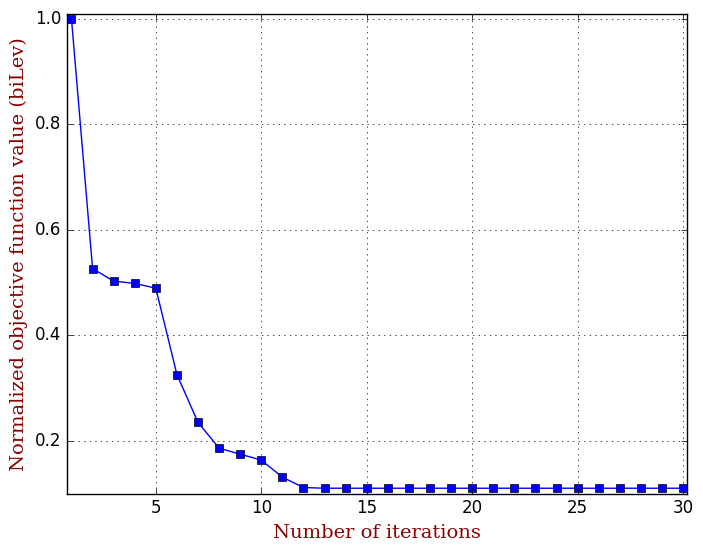

In [18]:
using PyPlot

iterNum = 1:(N+1)

objFun = map(iterNum->norObjFunDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, objFun, "s-b")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, N + 1 + .2)
ylim(minimum(objFun)-.01, maximum(objFun)+.01)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized objective function value (biLev)", fontdict=font1)

savefig("./results/objFun_biLev_Sioux.pdf")

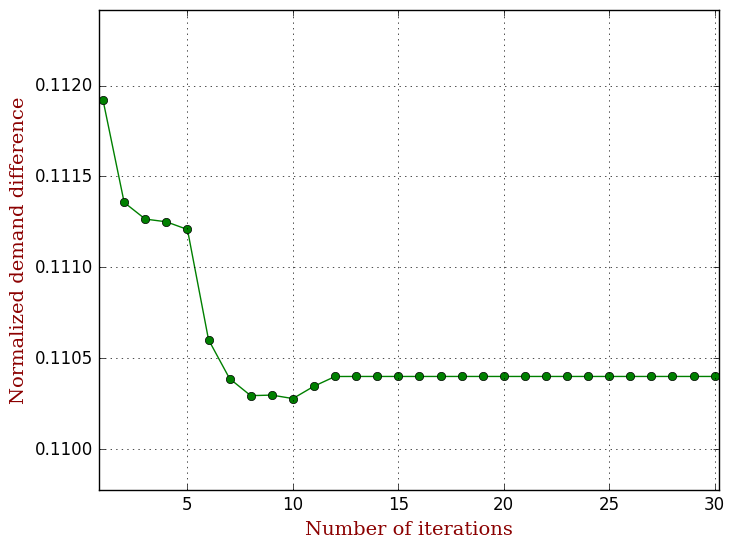

In [19]:
using PyPlot

iterNum = 1:(N+1)

demandsDiff = map(iterNum->demandsDiffDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, demandsDiff, "o-g")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, N + 1 + .2)
ylim(minimum(demandsDiff)-.0005, maximum(demandsDiff)+.0005)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized demand difference", fontdict=font1)

savefig("./results/demandsDiff_biLev_Sioux.pdf")

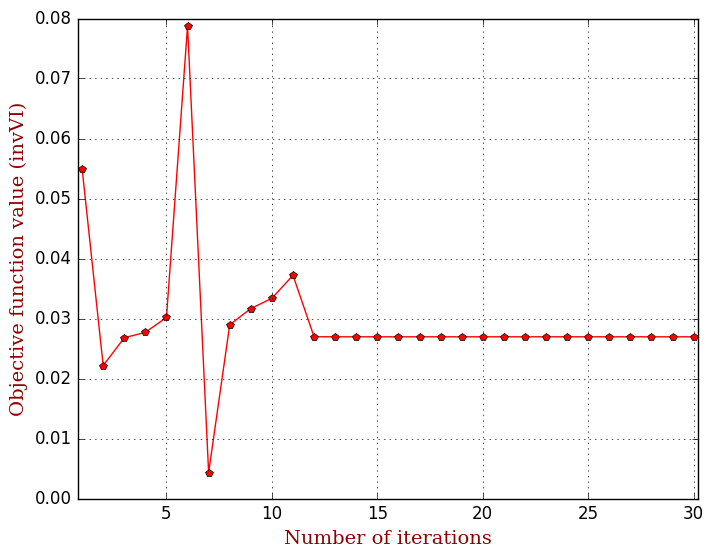

In [20]:
using PyPlot

iterNum = 1:(N+1)

objFun = map(iterNum->objInvVIDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, objFun, "p-r")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(0.8, N + 1 + .2)
# ylim(0.9, 2.0)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Objective function value (invVI)", fontdict=font1)

savefig("./results/objFun_invVI_Sioux.pdf")

In [21]:
coeffs_dict

Dict{(Int64,Float64,Float64,Int64),Array{Float64,1}} with 30 entries:
  (6,3.41,1.0,6)  => [1.0,0.04773537796521167,-0.14553900988861465,0.07575831178…
  (6,3.41,1.0,11) => [1.0,0.028375057370505257,-0.1183119752610036,0.11755514348…
  (6,3.41,1.0,20) => [1.0,0.028617094597184648,-0.12161963823906068,0.1301340539…
  (6,3.41,1.0,21) => [1.0,0.028617094597184648,-0.12161963823906068,0.1301340539…
  (6,3.41,1.0,25) => [1.0,0.028617094597184648,-0.12161963823906068,0.1301340539…
  (6,3.41,1.0,13) => [1.0,0.028617077658699416,-0.12161951556783397,0.1301337032…
  (6,3.41,1.0,30) => [1.0,0.028617094597184648,-0.12161963823906068,0.1301340539…
  (6,3.41,1.0,3)  => [1.0,0.009022361588409862,-0.05358604225309978,0.0813313854…
  (6,3.41,1.0,10) => [1.0,0.029076054710386257,-0.12208864661082498,0.1258146692…
  (6,3.41,1.0,8)  => [1.0,0.027026472070351613,-0.1161705780911203,0.12649064704…
  (6,3.41,1.0,15) => [1.0,0.028617094597184648,-0.12161963823906068,0.1301340539…
  (6,3.41,1.0,29) => [1.0,0.

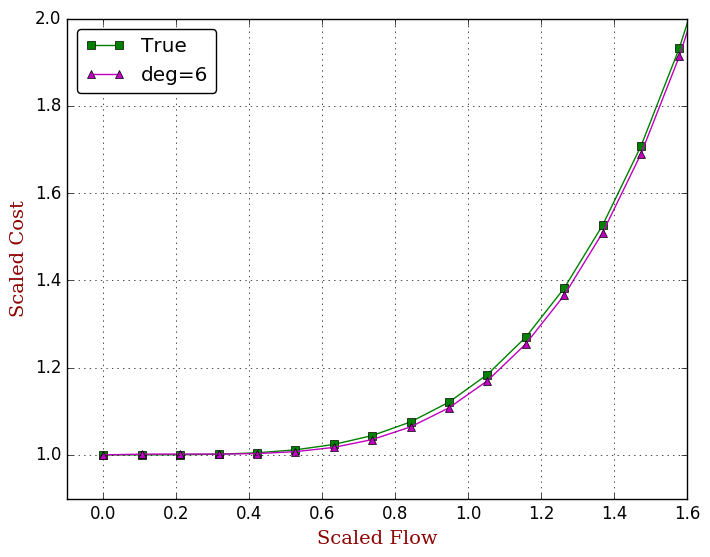

In [22]:
using PyPlot

iterN = 1

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Sioux_iter_$(iterN).pdf")

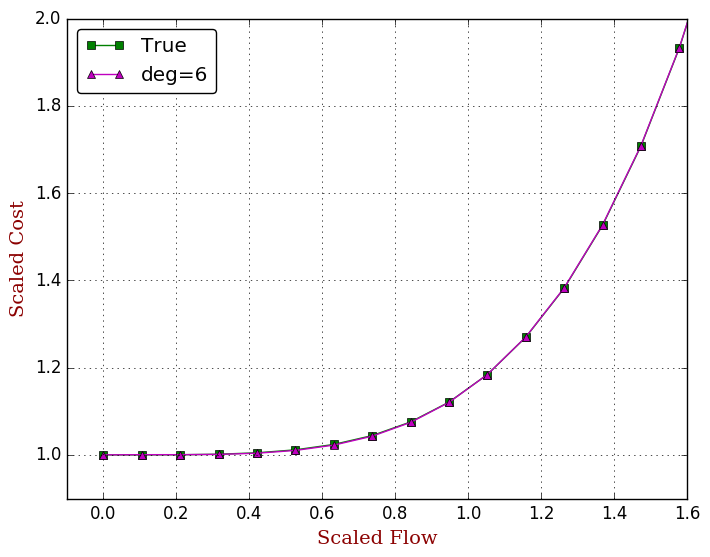

In [23]:
using PyPlot

iterN = 2

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Sioux_iter_$(iterN).pdf")

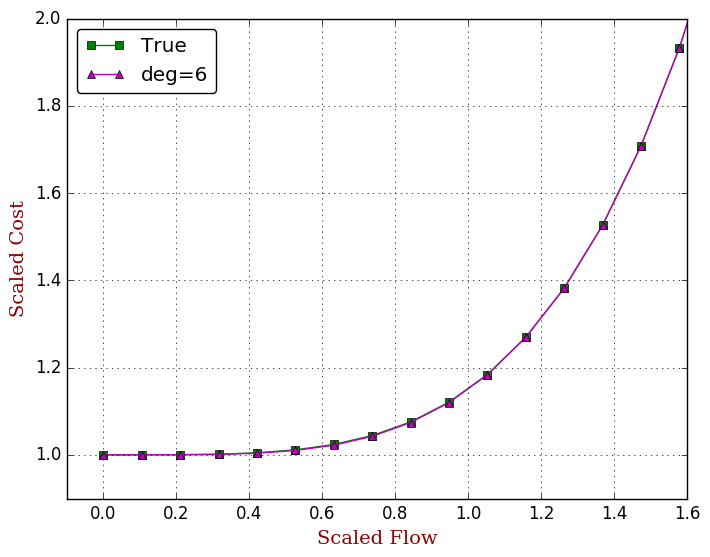

In [24]:
using PyPlot

iterN = 3

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Sioux_iter_$(iterN).pdf")

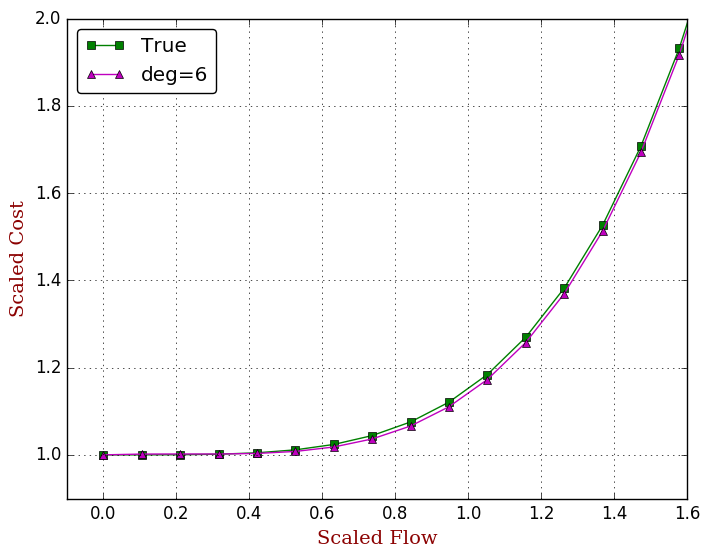

In [25]:
using PyPlot

iterN = N+1

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Sioux_iter_$(iterN).pdf")